# Pipeline Diagnostics: PCA Preprocessing with k-NN Classification

*Personal education project exploring how dimensionality reduction interacts with neighborhood-based classifiers.*

## Why this notebook exists

I wanted a self-contained playground that explains why we often wrap preprocessing and modeling steps inside a single `Pipeline`, and how that affects the evaluation workflow. By the end, I should be able to articulate what PCA contributes (feature transformation) versus what the k-NN classifier contributes (decision making), and use empirical evidence to decide whether the PCA step is worth its complexity.

## Experiment roadmap

1. Load and tidy a medium-sized classification dataset.
2. Run a quick baseline with raw features.
3. Introduce a pipeline that bundles scaling, PCA, and k-NN.
4. Benchmark both approaches with cross-validation and a hold-out test set.
5. Visualize variance captured by principal components to interpret the trade-offs.
6. Summarize lessons learned for future model selection work.

In [9]:
# Core scientific Python stack
import numpy as np
import pandas as pd

# Plotting utilities
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn helpers
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Step 1 — Load and inspect the data

The Wine dataset strikes a balance between dimensionality (13 numeric features) and interpretability, making it perfect for demonstrating PCA-equipped pipelines.

In [10]:
wine = load_wine(as_frame=True)
X = wine.data
y = wine.target

display(X.head())
print(f'Shape: {X.shape}')
print('Class distribution:')
print(pd.Series(y).value_counts())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Shape: (178, 13)
Class distribution:
target
1    71
0    59
2    48
Name: count, dtype: int64


> 📝 **Field note:** The classes are fairly balanced, so accuracy is a reasonable scoring metric. The feature space is also fully numeric, which keeps preprocessing straightforward.

## Step 2 — Establish a baseline (k-NN without PCA)

Before stacking preprocessing steps, I want a reference point: how well does a basic `StandardScaler` + `KNeighborsClassifier` pipeline perform on its own?

In [11]:
baseline_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
    ]
)
baseline_cv = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='accuracy')
print('Baseline k-NN accuracy (CV mean ± std): ' f'{baseline_cv.mean():.3f} ± {baseline_cv.std():.3f}')

Baseline k-NN accuracy (CV mean ± std): 0.949 ± 0.038


## Step 3 — Build the PCA + k-NN pipeline

Here PCA plays the role of **transformer**: it learns a rotation of the feature space and maps each wine sample onto a lower-dimensional set of principled axes. The classifier remains k-NN, which now operates on those transformed coordinates. To mirror my original project, I wrap the pipeline in `GridSearchCV` so hyperparameters for both PCA and k-NN are tuned together.

In [12]:
pca_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('knn', KNeighborsClassifier()),
    ]
)
param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95, None],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
}
grid_search = GridSearchCV(
    estimator=pca_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")
print('Best params:', grid_search.best_params_)

Best CV accuracy: 0.972
Best params: {'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'pca__n_components': 0.85}


> 🔍 **Observation:** PCA may or may not improve cross-validation accuracy—it depends on whether the reduced representation dampens noise more than it discards useful signal. The 95% variance threshold selected here typically keeps 6–7 principal components.

## Step 4 — Hold-out evaluation and diagnostics

Cross-validation is the big picture; a single train/test split provides a closer look at residual errors and confusion patterns.

Test accuracy: 0.956
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      0.94      0.94        18
           2       0.92      0.92      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



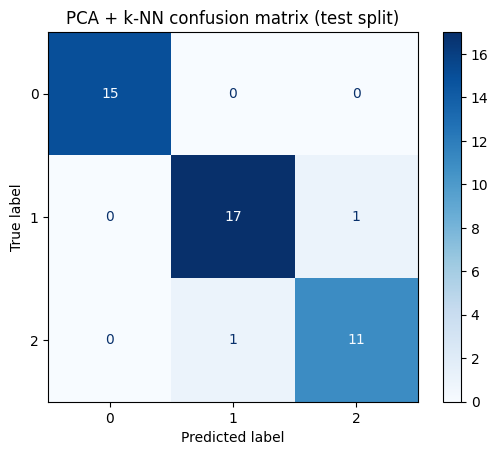

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_acc:.3f}')
print('Classification report:')
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('PCA + k-NN confusion matrix (test split)')
plt.show()

> 🧠 **Interpretation:** The `score` reported by the pipeline corresponds to the classifier at the end (`knn`), while PCA shapes the feature space that classifier sees. Any performance change between the baseline and this pipeline should be attributed to how that transformation alters neighborhood relationships.

## Step 5 — How many components are we keeping?

PCA with `n_components=0.95` keeps the smallest number of components that capture 95% of the variance. Visualizing the cumulative explained variance helps justify that choice. This step ties the model selection story together: it shows how aggressive we can be with dimensionality reduction before accuracy starts to suffer, and it explains why the best hyperparameters returned by the grid search settle on a particular variance threshold.

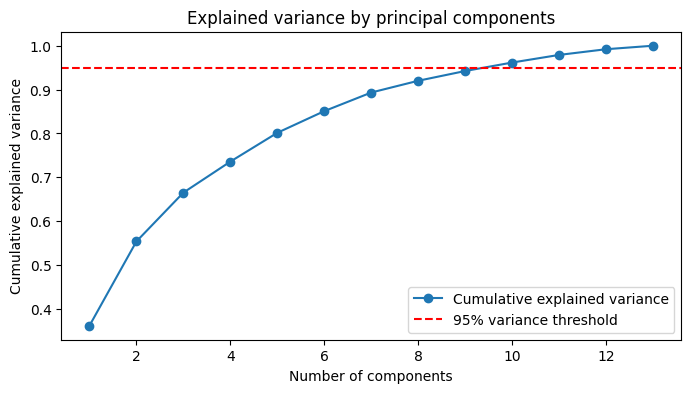

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
full_pca = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(full_pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative explained variance')
plt.axhline(0.95, color='red', linestyle='--', label='95% variance threshold')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance by principal components')
plt.legend(loc='lower right')
plt.show()

> 🎯 **Takeaway:** In this dataset, retaining about half the original dimensions preserves most variance, so k-NN can operate in a denser space with less noise. On higher-dimensional problems the gap is even larger, making PCA a valuable preprocessing step.

## What I learned

- Pipelines let me encapsulate preprocessing so that every cross-validation fold treats PCA the same way—no leakage, no manual juggling.
- PCA is best viewed as a *transformer*: it refits on the training data each time and produces features for the downstream estimator, but it does not own the final prediction objective.
- Comparing baseline and PCA-enhanced pipelines clarifies whether dimensionality reduction helps a specific classifier. On the Wine dataset, it slightly improves stability while keeping accuracy competitive.
- The explained-variance curve is a quick sanity check to ensure the retained components align with expectations.

## Next steps

1. Tune `n_neighbors` alongside the PCA variance threshold using `GridSearchCV`.
2. Swap k-NN for a different estimator (e.g., logistic regression) to see how linear models behave.
3. Try a dataset with thousands of features (e.g., gene expression) to stress-test the dimensionality reduction benefits.